In [56]:
import matplotlib.pyplot as plt
import random as r
import pprint as pp
import numpy as np
import csv

In [57]:
# Define type of slice and its parameters
slices_type = {
    'eMBB' : {
        'bandwidth_max': 100000000, #max bandwidth which BS can give to this slice
        'client_weight': 0.3, # Portion of clients which use this type of slice
        'band_guaranteed' : 0, # based on quality of service
        'min': 4000000, 
        'max': 800000000 # how much bps can require this type of slice
      },
      'URLLC' : {
        'bandwidth_max': 10000000,
        'client_weight': 0.2,
        'band_guaranteed' : 5000000,
        'min': 800,
        'max': 8000000
      },
      'MIoT' : {
        'bandwidth_max': 10000000,
        'client_weight': 0.15,
        'band_guaranteed' : 1000000,
        'min': 800000, 
        'max': 8000000
      },
      'mMTC' : {
        'bandwidth_max': 10000000,
        'client_weight': 0.15,
        'band_guaranteed' : 1000000,
        'min': 800000, 
        'max': 8000000
      },
      'voice' : {
        'bandwidth_max': 1000000,
        'client_weight': 0.2,
        'band_guaranteed' : 500000,
        'min': 4000000, 
        'max': 8000000
     }
}
          
# Define base station parameters
basestation = {
    'capacity': 20000000000,   #20Gbps
    'coverage': 250,
    'ratios': { # portion of capacity dedicated to various slice type
        'URLLC': 0.05,
        'eMBB': 0.65,
        'mMTC': 0.1,
        'voice': 0.1,
        'MIoT': 0.1
    },
    'x': 300,
    'y': 300
}

# Define mobility patterns and its parameters
mobility_patterns = {
  'car': {
    'distribution': 'normal',
    'params':(0,7),
    'client_weight': 0.10
  },
  'walk': {
    'distribution': 'randint',
    'params': (-1, 1),
    'client_weight': 0.40
  },
  'stationary': {
    'distribution': 'normal',
    'params': (0, 0.1),
    'client_weight': 0.20
  },
  'publictransport': {
    'distribution': 'randint',
    'params': (-4, 4),
    'client_weight': 0.10
  },
  'slackperson':{
    'distribution': 'randint',
    'params':(0, 1),
    'client_weight': 0.20
  }
}

In [58]:
# Define obj Client
class Client:
    def __init__(self, ID, x, y, mobility_pattern, freq, slice_type, slice_cap, bs):
        self.ID = ID
        self.x = x
        self.y = y
        self.mobility_pattern = mobility_pattern
        self.freq = freq
        self.slice_type = slice_type
        self.bs = bs
        self.slice_cap = slice_cap
        self.usage_rem = 0
        self.last_usage = 0
        self.connected = False
        
        # stats
        self.tot_connected_time = 0
        self.tot_unconnected_time = 0
        self.tot_requests = 0
        self.consume_time = 0
        self.tot_usage = 0
        
     # for each user we do 4 steps, at each iteration:
     # 1  Connection to BS and start consume
     # 2  Release consume
     # 3  Continue client movement
     
    def step_1(self):
        if self.bs is not None:
            if self.usage_rem > 0:
                if self.connected:
                    self.start_consume()
                else:
                    self.connect()
            else:
                if self.connected:
                    self.disconnect()
                else:
                    self.generate_usage_and_connect()
        
    def step_2(self):
        if self.connected and self.last_usage > 0:
            self.release_consume()
            if self.usage_rem == 0:
                self.disconnect()
    
    def step_3(self):
        x, y = self.move()
        self.x += x
        self.y += y
        if self.bs is not None:
            if not inRange(self, bs):
                self.disconnect()       
                
    def generate_usage_and_connect(self):
        if self.slice_type is not None:
            # Generate new usage
            self.usage_rem = self.generate()
            self.tot_requests += 1
            self.connect()
            print(f"Client_{self.ID}, coordinates : ({self.x}, {self.y}) requests {self.usage_rem} usage to BS{self.bs.ID}")     

    def connect(self):
        s = self.slice_type
        if self.connected:
            return
        if self.is_avaliable():         # threshold for usage
            self.connected = True
            bs.connected_users += 1
            print(f"Client {self.ID}, coordinates : ({self.x}, {self.y}) connected to slice {s} @ BS{self.bs.ID}")
            return True
       # if there is not enough band, the user waits the next time slot
        print(f"Client {self.ID}, coordinates : ({self.x}, {self.y}) connection refused to slice {s} @ BS{self.bs.ID}")
        return False
        
    def disconnect(self):
        if self.connected == True:
            bs.connected_users -= 1
            self.connected = False
        print(f"Client {self.ID}, coordinates: ({self.x},{self.y}) disconnected from slice {self.slice_type} @ BS{self.bs.ID} ")
        return not self.connected
    
    def start_consume(self):
        amount = min(self.usage_rem, self.get_consumable_share())    # bandwidth allocation
        bs.band_remaining -= amount  # BS allocate bandwidth and its capacity decreases
        bs.pot_band_remaining -= amount
        self.last_usage = amount
        print(f"Client {self.ID}, coordinates: ({self.x}, {self.y}) gets {amount} usage from @ BS{self.bs.ID}")
           
    def release_consume(self):
        # release resources
        if self.last_usage > 0:
            bs.band_remaining += self.last_usage
            self.consume_time += 1
            self.tot_usage += self.last_usage
            self.usage_rem -= self.last_usage
            print(f"Client {self.ID}, coordinates: ({self.x}, {self.y}), releases {self.last_usage} usage to BS{self.bs.ID}")
            self.last_usage = 0
        
    # update client coordinates (TODO)    
    def move(self):   
        distr = self.mobility_pattern.distribution
        params = self.mobility_pattern.params
        if distr == "randint":
            delta_x = r.randint(params[0], params[1])
            delta_y = r.randint(params[0], params[1])
            return delta_x, delta_y
        if distr == "normal":
            delta_x = np.random.normal(params[0], params[1])
            delta_y = np.random.normal(params[0], params[1])
            return delta_x, delta_y 
        
    # generate client consume   
    def generate(self):
        s = self.slice_type
        amount = r.randint(slices_type[s]['min'], slices_type[s]['max'])
        return amount
    
    def is_avaliable(self):
        global client_per_slice
        s = self.slice_type
        bandwidth_next = self.slice_cap / (client_per_slice[s] + 1)
        if bandwidth_next < slices_type[s]['band_guaranteed']:
            return False
        return True
      
    def get_consumable_share(self):
        global client_per_slice
        s = self.slice_type

        if client_per_slice.get(s) <= 0:
            return int(min(self.slice_cap, slices_type[s]['bandwidth_max'] ))
        else:
            return int(min(self.slice_cap/client_per_slice[s], slices_type[s]['bandwidth_max'] ))
            

In [59]:
# Define obj Mobility 
class Mobility:
    def __init__(self, name, distribution, params):
        self.name = name
        self.distribution = distribution
        self.params = params

In [60]:
# Define obj BaseStation
class BaseStation:
    def __init__(self,ID, x, y, coverage, capacity, ratios):
        self.ID =ID
        self.x = x
        self.y = y
        self.coverage = coverage
        self.capacity = capacity
        self.ratios = ratios
        self.pot_band_remaining = capacity
        self.band_remaining = capacity
        self.connected_users = 0

In [61]:
def get_random_mobility_pattern(vals, mobility_patterns):
    i = 0
    j = r.random()

    while vals[i] < j:
        i += 1

    return mobility_patterns[i]


def get_random_slice_type(vals):
    i = 0
    j = r.random()
    s = ''

    while vals[i] < j:
        i += 1
    
    if i == 0:
       s = 'eMBB'
    if i == 1:
       s = 'URLLC' 
    if i == 2:
       s = 'MIoT' 
    if i == 3:
       s = 'mMTC' 
    if i == 4:
       s = 'voice' 
    
    return s

def get_number_user_slice_type(all_client):
    embb = 0
    miot = 0
    mmtc = 0
    voice = 0 
    urllc = 0
    
    for c in all_client:
        if c.slice_type == 'eMBB':
            embb = embb + 1

        if c.slice_type == 'URLLC':
            urllc = urllc + 1

        if c.slice_type == 'MIoT':
            miot = miot + 1

        if c.slice_type == 'mMTC':
            mmtc = mmtc + 1

        if c.slice_type == 'voice':
            voice = voice + 1
    
    user_per_slice = {'eMBB': embb,
                      'URLLC': urllc,
                      'MIoT': miot,
                      'mMTC': mmtc,
                      'voice': voice
                     }
    
    return user_per_slice
        

def inRange(client, bs):
    x_client = client.x
    y_client = client.y
    x_bs = bs.x
    y_bs = bs.y
    if (abs(x_client - x_bs) < bs.coverage) and (abs(y_client - y_bs) < bs.coverage):
        return True
        print('true')
    else:
        return False
        print('false')

collected, slice_weights = 0, []
for key, value in slices_type.items():
    collected += value['client_weight']
    slice_weights.append(collected)

collected, mb_weights = 0, []
for key, value in mobility_patterns.items():
    collected += value['client_weight']
    mb_weights.append(collected)
    
m_patterns = []
for name, mb in mobility_patterns.items():
    mobility_pattern = Mobility(name, mb['distribution'], mb['params'])
    m_patterns.append(mobility_pattern)    

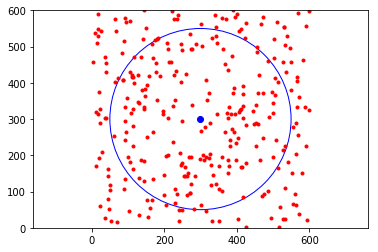

In [62]:
# Round 0: create network area, place base station and clients
num_clients = 300
simulation_time = 10
x_area = 600
y_area = 600

bs = BaseStation(0, basestation.get('x'), basestation.get('y'), basestation.get('coverage'), basestation.get('capacity'), basestation.get('ratios'))

clients = []
for i in range(num_clients):
    x = r.randint(0, x_area)
    y = r.randint(0, y_area)
    freq = r.random()
    
    mobility_pattern = get_random_mobility_pattern(mb_weights, m_patterns)
    slice_type = get_random_slice_type(slice_weights) 
    slice_capacity = bs.ratios.get(slice_type) * bs.capacity
    
    c = Client(i, x, y, mobility_pattern, freq, slice_type, slice_capacity, bs)
    clients.append(c)

ax = plt.gca()
plt.axis('equal')
ax.set_xlim(0, x_area)
ax.set_ylim(0, y_area)
ax.plot(bs.x, bs.y, 'o', color='blue')
circle = plt.Circle((bs.x,bs.y), radius = bs.coverage, fill=False, color='blue')
ax.add_artist(circle)
    
for i in range(num_clients):
    ax.plot(clients[i].x, clients[i].y,'.',color='red')

In [63]:
# Define class Request
class Request:
    def __init__(self, id_client, type_slice, traffic_request, traffic_left):
        self.id_client = id_client
        self.type_slice = type_slice
        self.traffic_request = traffic_request
        self.traffic_left = traffic_left
        
#Define class csv
class CsvData:
    def __init__(self, step, r_embb, g_embb, connect_embb, r_urllc, g_urllc, connect_urllc, r_miot, g_miot, connect_miot, r_mmtc, g_mmtc, connect_mmtc, r_voice, g_voice, connect_voice):
        self.step = step
        self.r_embb = r_embb
        self.g_embb = g_embb
        self.connect_embb = connect_embb
        self.r_urllc = r_urllc
        self.g_urllc = g_urllc
        self.connect_urllc = connect_urllc
        self.r_miot = r_miot
        self.g_miot = g_miot
        self.connect_miot = connect_miot
        self.r_mmtc = r_mmtc
        self.g_mmtc = g_mmtc
        self.connect_mmtc = connect_mmtc
        self.r_voice = r_voice
        self.g_voice = g_voice
        self.connect_voice = connect_voice

In [64]:
clients_inRange = []

for i in range(num_clients):
    if inRange(clients[i], bs):
        clients_inRange.append(clients[i])

# create fixed size list to manage the request
request_list = [None] * len(clients)
active_clients = []
csv_final = []

for n in range(simulation_time):
    
    # manage number active clients
    active = []
    new_connection = r.randint(0, len(clients_inRange))
    active = r.sample(clients_inRange, new_connection)
    
    for j in range(len(active)):
        if request_list[active[j].ID] == None:
            active_clients.append(active[j])
            
    client_per_slice = get_number_user_slice_type(active_clients)
    
    print(client_per_slice.get('voice'))
    
    print('STEP', n)
    
    for i in range(len(active_clients)):   
        # step 1 and create request
        active_clients[i].step_1()
        
        req = Request(active_clients[i].ID, active_clients[i].slice_type, active_clients[i].usage_rem, active_clients[i].usage_rem)
        request_list[active_clients[i].ID] = req
    
    for i in range(len(active_clients)):
        # step 2 and update request (delete non active user, and update traffic)
        active_clients[i].step_2()
        request_list[active_clients[i].ID].traffic_left = active_clients[i].usage_rem
    
    user_embb, user_urllc, user_miot, user_mmtc, user_voice = 0, 0, 0, 0, 0
    req_embb, req_urllc, req_miot, req_mmtc, req_voice = 0, 0, 0, 0, 0
    giv_embb, giv_urllc, giv_miot, giv_mmtc, giv_voice = 0, 0, 0, 0, 0
    for item in request_list:
     if item is not None:
        if item.type_slice == 'eMBB':
            if item.traffic_request - item.traffic_left != 0:
                req_embb += item.traffic_request
                giv_embb += item.traffic_request - item.traffic_left
                user_embb += 1   
            else:
                req_embb += 0
                giv_embb += 0
                user_embb += 1   
        if item.type_slice == 'URLLC' :
            if item.traffic_request - item.traffic_left != 0:
                req_urllc += item.traffic_request
                giv_urllc += item.traffic_request - item.traffic_left
                user_urllc += 1
            else:
                req_urllc += 0
                giv_urllc += 0
                user_urllc += 1   
        if item.type_slice == 'MIoT':
            if item.traffic_request - item.traffic_left != 0:
                req_miot += item.traffic_request
                giv_miot += item.traffic_request - item.traffic_left
                user_miot += 1
            else:
                req_miot += 0
                giv_miot += 0
                user_miot += 1   
        if item.type_slice == 'mMTC':
            if item.traffic_request - item.traffic_left != 0:
                req_mmtc += item.traffic_request
                giv_mmtc += item.traffic_request - item.traffic_left
                user_mmtc += 1
            else:
                req_mmtc += 0
                giv_mmtc += 0
                user_mmtc += 1   
        if item.type_slice == 'voice':
            if item.traffic_request - item.traffic_left != 0:
                req_voice += item.traffic_request
                giv_voice += item.traffic_request - item.traffic_left
                user_voice += 1   
            else:
                req_voice += 0
                giv_voice += 0
                user_voice += 1 
           
    csv_data = CsvData(n, req_embb, giv_embb, user_embb, req_urllc, giv_urllc, user_urllc, req_miot, giv_miot, user_miot, req_mmtc, giv_mmtc, user_mmtc, req_voice, giv_voice, user_voice)  
    csv_final.append(csv_data)
    
    for i in range(len(active_clients)):
        if active_clients[i].connected == False:
            request_list[active_clients[i].ID] = None

    for item in active_clients:
        # step 3 and delete also user not in range
        item.step_3()
        if item.connected == False:
            request_list[item.ID] = None
            active_clients.remove(item)
    

38
STEP 0
Client 246, coordinates : (475, 92) connected to slice MIoT @ BS0
Client_246, coordinates : (475, 92) requests 3025791 usage to BS0
Client 100, coordinates : (417, 335) connected to slice eMBB @ BS0
Client_100, coordinates : (417, 335) requests 137691432 usage to BS0
Client 61, coordinates : (422, 523) connected to slice URLLC @ BS0
Client_61, coordinates : (422, 523) requests 1603859 usage to BS0
Client 39, coordinates : (169, 263) connected to slice URLLC @ BS0
Client_39, coordinates : (169, 263) requests 3084374 usage to BS0
Client 89, coordinates : (175, 517) connected to slice URLLC @ BS0
Client_89, coordinates : (175, 517) requests 5076855 usage to BS0
Client 96, coordinates : (128, 346) connected to slice mMTC @ BS0
Client_96, coordinates : (128, 346) requests 7480024 usage to BS0
Client 199, coordinates : (64, 401) connected to slice voice @ BS0
Client_199, coordinates : (64, 401) requests 7591080 usage to BS0
Client 36, coordinates : (549, 381) connected to slice eMB

Client 248, coordinates: (278, 339) gets 100000000 usage from @ BS0
Client 40, coordinates: (233.9367302057422, 92.99514875252792) gets 1000000 usage from @ BS0
Client 188, coordinates : (110.95558273412773, 421.06311874933186) connected to slice mMTC @ BS0
Client_188, coordinates : (110.95558273412773, 421.06311874933186) requests 1187453 usage to BS0
Client 267, coordinates: (167, 133) gets 1000000 usage from @ BS0
Client 193, coordinates: (457, 486) gets 5733404 usage from @ BS0
Client 4, coordinates: (274, 495) gets 84060901 usage from @ BS0
Client 1, coordinates: (244.14872072071478, 296.6257190811453) gets 1780069 usage from @ BS0
Client 203, coordinates: (532.0876397883208, 66.35508777512395) gets 7250245 usage from @ BS0
Client 14, coordinates: (461, 422) gets 100000000 usage from @ BS0
Client 292, coordinates: (316, 193) gets 100000000 usage from @ BS0
Client 33, coordinates : (197, 323) connected to slice URLLC @ BS0
Client_33, coordinates : (197, 323) requests 3340413 usage 

Client 54, coordinates : (410, 326) connected to slice URLLC @ BS0
Client_54, coordinates : (410, 326) requests 179680 usage to BS0
Client 240, coordinates : (453, 501) connected to slice URLLC @ BS0
Client_240, coordinates : (453, 501) requests 3437560 usage to BS0
Client 42, coordinates : (71, 411) connected to slice mMTC @ BS0
Client_42, coordinates : (71, 411) requests 1396327 usage to BS0
Client 1, coordinates : (256.9307327106573, 297.33261125831876) connected to slice URLLC @ BS0
Client_1, coordinates : (256.9307327106573, 297.33261125831876) requests 7954188 usage to BS0
Client 193, coordinates : (457, 486) connected to slice MIoT @ BS0
Client_193, coordinates : (457, 486) requests 4208313 usage to BS0
Client 226, coordinates : (345, 511) connected to slice eMBB @ BS0
Client_226, coordinates : (345, 511) requests 396344465 usage to BS0
Client 276, coordinates : (163, 55) connected to slice MIoT @ BS0
Client_276, coordinates : (163, 55) requests 3767189 usage to BS0
Client 110, 

Client 253, coordinates : (170, 79) connected to slice mMTC @ BS0
Client_253, coordinates : (170, 79) requests 4283406 usage to BS0
Client 164, coordinates : (381.0519967320868, 241.0391918716431) connected to slice mMTC @ BS0
Client_164, coordinates : (381.0519967320868, 241.0391918716431) requests 3045179 usage to BS0
Client 195, coordinates : (101, 194) connected to slice MIoT @ BS0
Client_195, coordinates : (101, 194) requests 7840260 usage to BS0
Client 23, coordinates : (390.9242641454937, 372.93727287972416) connected to slice mMTC @ BS0
Client_23, coordinates : (390.9242641454937, 372.93727287972416) requests 6756825 usage to BS0
Client 211, coordinates : (539, 530) connected to slice URLLC @ BS0
Client_211, coordinates : (539, 530) requests 6656470 usage to BS0
Client 54, coordinates: (411, 327) gets 2334547 usage from @ BS0
Client 14, coordinates: (461, 422) gets 100000000 usage from @ BS0
Client 110, coordinates: (314, 279) gets 1155591 usage from @ BS0
Client 219, coordinat

Client 63, coordinates: (263.924664940561, 193.41624607845736) gets 5243824 usage from @ BS0
Client 165, coordinates: (223, 464) gets 100000000 usage from @ BS0
Client 177, coordinates: (467, 190) gets 100000000 usage from @ BS0
Client 65, coordinates: (261, 427) gets 1600456 usage from @ BS0
Client 181, coordinates: (304, 205) gets 6600973 usage from @ BS0
Client 15, coordinates: (535, 428) gets 7269267 usage from @ BS0
Client 127, coordinates: (317.13597416829174, 352.2571883363004) gets 757618 usage from @ BS0
Client 98, coordinates: (221, 303) gets 5163056 usage from @ BS0
Client 206, coordinates: (330, 523) gets 5338505 usage from @ BS0
Client 243, coordinates: (145.22380908485917, 128.2387978885354) gets 2254921 usage from @ BS0
Client 197, coordinates: (247, 180) gets 6926290 usage from @ BS0
Client 257, coordinates: (527, 215) gets 100000000 usage from @ BS0
Client 79, coordinates : (112, 425) connected to slice URLLC @ BS0
Client_79, coordinates : (112, 425) requests 4097559 u

Client 34, coordinates: (311, 186) gets 38441701 usage from @ BS0
Client 94, coordinates : (272, 92) connected to slice eMBB @ BS0
Client_94, coordinates : (272, 92) requests 264168630 usage to BS0
Client 260, coordinates: (263, 90) gets 100000000 usage from @ BS0
Client 86, coordinates: (454, 289) gets 1000000 usage from @ BS0
Client 222, coordinates: (353, 170) gets 1000000 usage from @ BS0
Client 171, coordinates: (467.2630839452845, 315.94160781711224) gets 1000000 usage from @ BS0
Client 17, coordinates: (287.9326306991839, 194.56547774308257) gets 903835 usage from @ BS0
Client 149, coordinates: (212, 514) gets 100000000 usage from @ BS0
Client 258, coordinates: (205, 198) gets 91138979 usage from @ BS0
Client 106, coordinates: (508.8708504039175, 243.08512441719324) gets 1000000 usage from @ BS0
Client 3, coordinates: (501, 320) gets 1000000 usage from @ BS0
Client 113, coordinates: (537, 114) gets 100000000 usage from @ BS0
Client 77, coordinates: (419, 390) gets 99816667 usage

Client 135, coordinates : (176, 429) connected to slice eMBB @ BS0
Client_135, coordinates : (176, 429) requests 247797384 usage to BS0
Client 63, coordinates: (263.924664940561, 193.41624607845736) gets 2153454 usage from @ BS0
Client 9, coordinates : (472.9247588011411, 246.76727518715984) connected to slice eMBB @ BS0
Client_9, coordinates : (472.9247588011411, 246.76727518715984) requests 586151736 usage to BS0
Client 254, coordinates : (276, 493) connected to slice eMBB @ BS0
Client_254, coordinates : (276, 493) requests 162988840 usage to BS0
Client 181, coordinates: (304, 205) gets 4454328 usage from @ BS0
Client 67, coordinates : (392.7200533863955, 384.95426545702986) connected to slice URLLC @ BS0
Client_67, coordinates : (392.7200533863955, 384.95426545702986) requests 2470409 usage to BS0
Client 276, coordinates : (163, 56) connected to slice MIoT @ BS0
Client_276, coordinates : (163, 56) requests 7841996 usage to BS0
Client 79, coordinates : (116, 420) connected to slice U

Client 287, coordinates: (271.0538738765156, 533.6547965262738) gets 3411613 usage from @ BS0
Client 13, coordinates: (180, 351) gets 6565414 usage from @ BS0
Client 55, coordinates: (137.8059291118243, 381.0001579595351) gets 1000000 usage from @ BS0
Client 204, coordinates: (224.4882448501744, 400.28414017073106) gets 100000000 usage from @ BS0
Client 18, coordinates: (378.2241035456145, 332.44732354473945) gets 100000000 usage from @ BS0
Client 1, coordinates: (255.0192253433561, 299.06723901746005) gets 3527091 usage from @ BS0
Client 225, coordinates: (427, 182) gets 3112168 usage from @ BS0
Client 98, coordinates: (219, 309) gets 3554189 usage from @ BS0
Client 197, coordinates : (246, 180) connected to slice URLLC @ BS0
Client_197, coordinates : (246, 180) requests 7523501 usage to BS0
Client 10, coordinates: (114, 280) gets 7527192 usage from @ BS0
Client 54, coordinates : (410, 327) connected to slice URLLC @ BS0
Client_54, coordinates : (410, 327) requests 5283786 usage to BS

Client 281, coordinates : (315.8632503568632, 149.46413428643197) connected to slice mMTC @ BS0
Client_281, coordinates : (315.8632503568632, 149.46413428643197) requests 6506441 usage to BS0
Client 88, coordinates: (538, 510) gets 6956326 usage from @ BS0
Client 209, coordinates: (375.830369865341, 171.95504416027683) gets 2727692 usage from @ BS0
Client 239, coordinates: (49, 104) gets 1000000 usage from @ BS0
Client 211, coordinates: (540, 531) gets 3583645 usage from @ BS0
Client 54, coordinates : (409, 327) connected to slice URLLC @ BS0
Client_54, coordinates : (409, 327) requests 1545051 usage to BS0
Client 197, coordinates: (246, 180) gets 2100811 usage from @ BS0
Client 12, coordinates: (418, 370) gets 1000000 usage from @ BS0
Client 29, coordinates : (389, 272) connected to slice MIoT @ BS0
Client_29, coordinates : (389, 272) requests 7167575 usage to BS0
Client 186, coordinates : (245, 402) connected to slice URLLC @ BS0
Client_186, coordinates : (245, 402) requests 4924278 

In [65]:
for item in csv_final:
    print('STEP', item.step)
    print(item.r_urllc, item.g_urllc, item.connect_urllc)

STEP 0
0 0 29
STEP 1
131690096 131690096 31
STEP 2
40023380 40023380 33
STEP 3
111129082 111129082 39
STEP 4
82442041 82442041 37
STEP 5
77349551 77349551 40
STEP 6
118491395 118491395 37
STEP 7
62213516 62213516 37
STEP 8
99868079 99868079 31
STEP 9
33063756 33063756 17


In [66]:
with open('input.csv', mode='w') as csv_file:
    fieldnames = ['embb_rate', 'embb_users', 'embb_req', 'urllc_rate', 'urllc_users', 'urllc_req', 'miot_rate', 'miot_users', 'miot_req', 'mmtc_rate', 'mmtc_users', 'mmtc_req', 'voice_rate', 'voice_users', 'voice_req']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    writer.writeheader()
    for item in csv_final:
        writer.writerow({'embb_rate': item.g_embb, 'embb_users': item.connect_embb, 'embb_req': item.r_embb, 'urllc_rate': item.g_urllc, 'urllc_users': item.connect_urllc, 'urllc_req': item.r_urllc, 'miot_rate': item.g_miot, 'miot_users': item.connect_miot, 'miot_req': item.r_miot, 'mmtc_rate': item.g_mmtc, 'mmtc_users': item.connect_mmtc, 'mmtc_req': item.r_mmtc, 'voice_rate': item.g_voice, 'voice_users': item.connect_voice, 'voice_req': item.r_voice,})
    